# Neural Network

## Import Necessary Packages

In [2]:
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [ ]:
# set deterministic behaviour so tuning experiments are reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## Data Preprocessing

In [ ]:
# read in cleaned merged data
df = pd.read_csv("../data/clean_merged.csv")
print(df.head())
print(df.columns)

        id  code_gender  flag_own_car  flag_own_realty  cnt_children  \
0  5008804            1             1                1             0   
1  5008805            1             1                1             0   
2  5008806            1             1                1             0   
3  5008808            0             0                1             0   
4  5008809            0             0                1             0   

   amt_income_total      name_income_type            name_education_type  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     name_family_status  name_housing_type  ...  cnt_fam_members  age  \
0        Civil marriage   Rented apar

In [ ]:
# remove columns that are not relevant for prediction
# leaky features that would not be available at prediction time
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
# labels and ids would not be useful for prediction
X = df.drop(columns=['label', 'id', 'amt_income_total'] + leaky_features)
y = df['label'].astype('int')

In [22]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
else:
    X_encoded = X

X_encoded.head()
X_encoded.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email',
       'cnt_fam_members', 'age', 'is_employed', 'years_employed',
       'amt_income_log', 'name_income_type_Pensioner',
       'name_income_type_State servant', 'name_income_type_Student',
       'name_income_type_Working', 'name_education_type_Higher education',
       'name_education_type_Incomplete higher',
       'name_education_type_Lower secondary',
       'name_education_type_Secondary / secondary special',
       'name_family_status_Married', 'name_family_status_Separated',
       'name_family_status_Single / not married', 'name_family_status_Widow',
       'name_housing_type_House / apartment',
       'name_housing_type_Municipal apartment',
       'name_housing_type_Office apartment',
       'name_housing_type_Rented apartment', 'name_housing_type_With parents',
       'occupation_type_Cleaning staff', 'occupation_type_Cooking staff',
 

In [23]:
# split once for train/validation/test so evaluation stays unbiased

# split into train (72%), val (8%), test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.1,
    random_state=SEED,
    stratify=y_train_full,
)

scaler = MinMaxScaler()
# min-max scale on train set, apply to val and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# check class distribution in each split
train_class_counts = Counter(y_train)
val_class_counts = Counter(y_val)
test_class_counts = Counter(y_test)

train_class_counts, val_class_counts, test_class_counts


(Counter({0: 25804, 1: 444}),
 Counter({0: 2868, 1: 49}),
 Counter({0: 7169, 1: 123}))

In [ ]:
# balance only the training fold; keep validation/test untouched
smote = SMOTE(random_state=SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Original training distribution:", train_class_counts)
print("Balanced training distribution:", Counter(y_train_balanced))

# compute pos_weight for BCEWithLogitsLoss
pos_weight_value = train_class_counts[0] / train_class_counts[1]
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)


Original training distribution: Counter({0: 25804, 1: 444})
Balanced training distribution: Counter({0: 25804, 1: 25804})


In [ ]:
# build tensors and loaders; batches move to GPU/CPU device inside the loop
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train_balanced).reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy().reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32)

batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Neural Network Set Up

In [25]:
# three-layer MLP that emits logits; dropout helps regularise high-dimensional features
class NN(nn.Module):
    def __init__(self, input_dim, hidden_layers=128, dropout_rate=0.2):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_layers)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)

        self.layer2 = nn.Linear(hidden_layers, hidden_layers)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)

        self.layer3 = nn.Linear(hidden_layers, hidden_layers)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout_rate)

        self.output = nn.Linear(hidden_layers, 1)

    def forward(self, x):
        x = self.drop1(self.act1(self.layer1(x)))
        x = self.drop2(self.act2(self.layer2(x)))
        x = self.drop3(self.act3(self.layer3(x)))
        x = self.output(x)
        return x


## Neural Network Training

In [27]:
input_dim = X_train_tensor.shape[1]  # get number of features after encoding
nn_base_model = NN(input_dim).to(device)

# weighted loss + regularisation to reflect true imbalance and stabilise training
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(nn_base_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

epochs = 80
patience = 10
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []
best_val_loss = float("inf")
early_stop_counter = 0
best_state_dict = copy.deepcopy(nn_base_model.state_dict())


In [28]:
for epoch in range(epochs):
    nn_base_model.train()
    epoch_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        logits = nn_base_model(X_batch)
        loss = criterion(logits, Y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nn_base_model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    nn_base_model.eval()
    val_loss = 0.0
    val_logits = []
    val_targets = []

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            logits = nn_base_model(X_batch)
            loss = criterion(logits, Y_batch)

            val_loss += loss.item()
            val_logits.append(logits.cpu())
            val_targets.append(Y_batch.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    logits_tensor = torch.cat(val_logits).squeeze()
    targets_tensor = torch.cat(val_targets).squeeze()
    probs = torch.sigmoid(logits_tensor)
    preds = (probs >= 0.5).float()
    val_accuracy = (preds == targets_tensor).float().mean().item()
    val_accuracies.append(val_accuracy)

    try:
        val_auc = roc_auc_score(targets_tensor.numpy(), probs.numpy())
    except ValueError:
        val_auc = float("nan")
    val_aucs.append(val_auc)

    print(
        f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}"
    )

    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        best_state_dict = copy.deepcopy(nn_base_model.state_dict())
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

nn_base_model.load_state_dict(best_state_dict)


Epoch 1/80, Train Loss: 3.3388, Val Loss: 3.4709, Val Acc: 0.0168, Val AUC: 0.5537
Epoch 2/80, Train Loss: 2.1910, Val Loss: 3.2444, Val Acc: 0.1224, Val AUC: 0.6042
Epoch 3/80, Train Loss: 1.8854, Val Loss: 3.0108, Val Acc: 0.2701, Val AUC: 0.6300
Epoch 4/80, Train Loss: 1.6952, Val Loss: 2.8736, Val Acc: 0.3949, Val AUC: 0.6470
Epoch 5/80, Train Loss: 1.5663, Val Loss: 3.0565, Val Acc: 0.4422, Val AUC: 0.6535
Epoch 6/80, Train Loss: 1.4594, Val Loss: 3.1455, Val Acc: 0.4981, Val AUC: 0.6601
Epoch 7/80, Train Loss: 1.3669, Val Loss: 3.2518, Val Acc: 0.4988, Val AUC: 0.6761
Epoch 8/80, Train Loss: 1.3043, Val Loss: 3.2806, Val Acc: 0.5701, Val AUC: 0.6896
Epoch 9/80, Train Loss: 1.2126, Val Loss: 3.3819, Val Acc: 0.6034, Val AUC: 0.6913
Epoch 10/80, Train Loss: 1.1738, Val Loss: 3.4637, Val Acc: 0.5783, Val AUC: 0.6971
Epoch 11/80, Train Loss: 1.1374, Val Loss: 3.4308, Val Acc: 0.6085, Val AUC: 0.7051
Epoch 12/80, Train Loss: 1.1268, Val Loss: 3.4111, Val Acc: 0.6027, Val AUC: 0.7059
E

<All keys matched successfully>

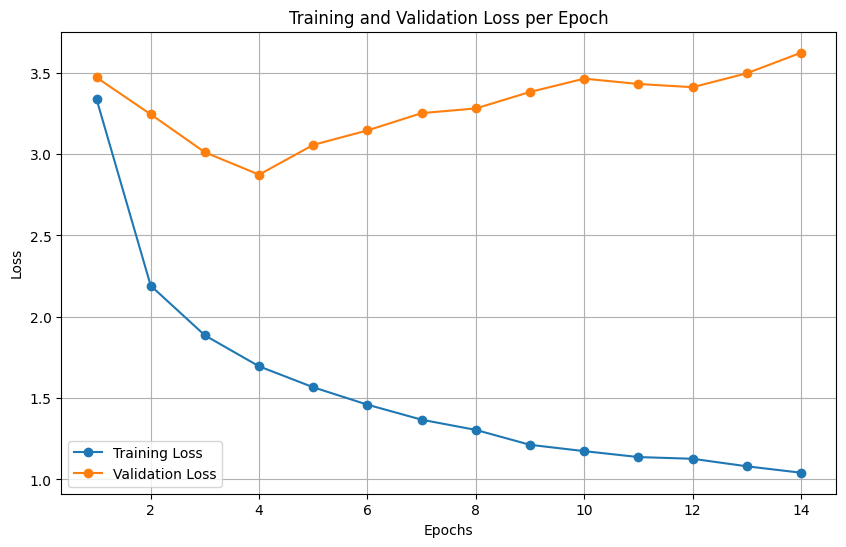

In [29]:
num_epochs_run = len(train_losses)
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs_run + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs_run + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


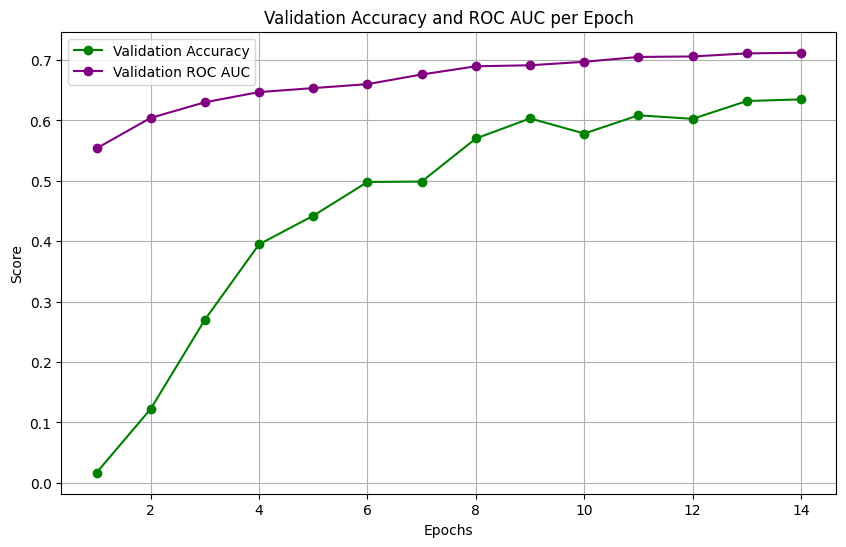

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_run + 1), val_accuracies, marker='o', label='Validation Accuracy', color='green')
plt.plot(range(1, num_epochs_run + 1), val_aucs, marker='o', label='Validation ROC AUC', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Accuracy and ROC AUC per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# evaluate on the untouched test set using probabilities for calibrated metrics
nn_base_model.eval()
test_logits = []
test_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        logits = nn_base_model(X_batch)
        test_logits.append(logits.cpu())
        test_targets.append(Y_batch.cpu())

test_logits = torch.cat(test_logits).squeeze()
test_targets = torch.cat(test_targets).squeeze()

test_probs = torch.sigmoid(test_logits).numpy()
test_preds = (test_probs >= 0.5).astype(int)
test_targets_np = test_targets.numpy().astype(int)

print("Classification Report:")
print(classification_report(test_targets_np, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_targets_np, test_preds))
try:
    print("ROC AUC Score:", roc_auc_score(test_targets_np, test_probs))
except ValueError:
    print("ROC AUC Score: NaN (only one class present)")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.36      0.53      7169
           1       0.02      0.78      0.04       123

    accuracy                           0.37      7292
   macro avg       0.51      0.57      0.28      7292
weighted avg       0.97      0.37      0.52      7292

Confusion Matrix:
[[2590 4579]
 [  27   96]]
ROC AUC Score: 0.631976316275926
